# Stock Price LSTM Model

## Libraries

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

## Dataset

In [34]:
ticker = input("Type in the stock ticker: ")
start_date = input("Type in a start date (Ex.: 2010-01-01): ")

end_date = datetime.today().strftime('%Y-%m-%d')

data_downloaded = yf.download(ticker, start=start_date, end=end_date)
data = data_downloaded

Type in the stock ticker: aapl
Type in a start date (Ex.: 2010-01-01): 2020-01-01
[*********************100%***********************]  1 of 1 completed


## Preparation

In [35]:
#drop all columns but Adj Close or else the Model won't work because of the extra columns of the dataframe
data=data[['Adj Close']]

## Stationarity

In [36]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

# Augmented Dickey-Fuller (ADF) Test: The ADF test is a statistical hypothesis test commonly used to determine stationarity.
# It tests the null hypothesis that a unit root is present in the series, indicating non-stationarity. 
#If the p-value obtained from the ADF test is below a certain significance level (e.g., 0.05), we reject the null hypothesis and conclude that the series is stationary. 
#The ADF test also provides a test statistic and critical values for different significance levels to compare against the obtained test statistic.
     
def evaluate_stationarity(series):
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print('ADF Statistic:', adf_statistic)
    print('p-value:', p_value)
    print('\nCritical Values:\n')
    for key, value in critical_values.items():
        if adf_statistic < value:
            print(f"Stationary: ADF statistic is lower than the critical value at {key} ({value}) level of significance.\n")
        else:
            print(f"Non-stationary: ADF statistic is higher than the critical value at {key} ({value}) level of significance.\n")

adj_close = data['Adj Close']
evaluate_stationarity(adj_close)

ADF Statistic: -1.4170216145773993
p-value: 0.5740890879457661

Critical Values:

Non-stationary: ADF statistic is higher than the critical value at 1% (-3.437897435722137) level of significance.

Non-stationary: ADF statistic is higher than the critical value at 5% (-2.8648716746706326) level of significance.

Non-stationary: ADF statistic is higher than the critical value at 10% (-2.568544030438542) level of significance.



## Normalize

In [37]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values)
fig, ax = plt.subplots()
ax.plot(data_scaled)


ax.set_xlabel('Time')
ax.set_ylabel('Scaled Value')
ax.set_title('Scaled Data')
plt.show()

## Train & Test sizes

In [38]:
# Split the data into train and test sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

## Features

In [ ]:

# Define the input sequence length and number of features
n_steps = 7
n_features = data.shape[1]

## Input & Output

In [39]:
# Create the input and output data for the LSTM model
X_train, y_train = [], []
for i in range(n_steps, len(train_data)):
    X_train.append(train_data[i - n_steps:i])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_steps, len(test_data)):
    X_test.append(test_data[i - n_steps:i])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

## Model

Epoch 1/10
22/22 [==============================] - 7s 23ms/step - loss: 0.0981
Epoch 2/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0107
Epoch 3/10
22/22 [==============================] - 0s 16ms/step - loss: 0.0074
Epoch 4/10
22/22 [==============================] - 0s 18ms/step - loss: 0.0055
Epoch 5/10
22/22 [==============================] - 0s 22ms/step - loss: 0.0049
Epoch 6/10
22/22 [==============================] - 0s 15ms/step - loss: 0.0047
Epoch 7/10
22/22 [==============================] - 0s 21ms/step - loss: 0.0050
Epoch 8/10
22/22 [==============================] - 0s 17ms/step - loss: 0.0050
Epoch 9/10
22/22 [==============================] - 0s 15ms/step - loss: 0.0041
Epoch 10/10
22/22 [==============================] - 0s 15ms/step - loss: 0.0040


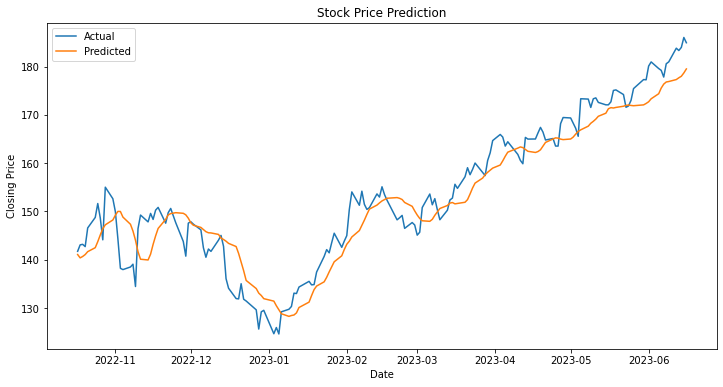

In [40]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')a

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Reshape predictions to match the scaler's expected shape
predictions = predictions.reshape(-1, 1)

# Unnormalize the predictions
predictions_unscaled = scaler.inverse_transform(predictions)

# Plot the test data, predicted values, and input/output sequences
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + n_steps:], data['Adj Close'].values[train_size + n_steps:], label='Actual')
plt.plot(data.index[train_size + n_steps:], predictions_unscaled, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

## Prediction

In [50]:
days = input("Number of days to predict: ")
days =int(days)

Number of days to predict: 45


1/1 [==============================] - 0s 38ms/step


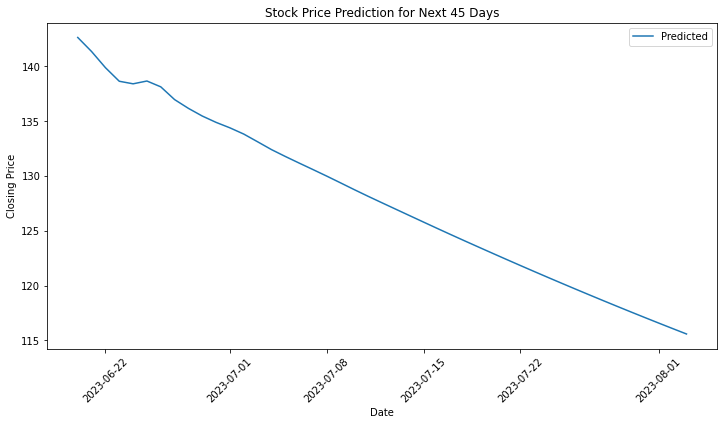

In [51]:
# Determine the last input sequence from the training data
last_sequence = X_train[-1]

# Initialize array to store predicted values
predicted_values = []

# Predict days ahead
for _ in range(days):
    # Reshape input sequence to match the model's input shape
    input_sequence = last_sequence.reshape(1, n_steps, n_features)

    # Use the model to predict the next day's value
    predicted_value = model.predict(input_sequence)[0][0]

    # Append the predicted value to the array
    predicted_values.append(predicted_value)

    # Update the input sequence
    last_sequence = np.append(last_sequence[1:], predicted_value)

# Unnormalize the predicted values
predicted_values_unscaled = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Plot the actual data, predicted values, and input/output sequences
# Get today's date
today = datetime.date.today()

# Create dates for the next days
next_days = [today + datetime.timedelta(days=i) for i in range(days)]

# Plot the predicted values for the next days
plt.figure(figsize=(12, 6))
plt.plot(next_days, predicted_values_unscaled, label='Predicted')
plt.title(f'Stock Price Prediction for Next {days} Days')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [52]:
print(predicted_values_unscaled)

[[142.61028 ]
 [141.328   ]
 [139.85826 ]
 [138.62042 ]
 [138.3872  ]
 [138.64215 ]
 [138.1117  ]
 [136.94856 ]
 [136.14894 ]
 [135.45047 ]
 [134.87239 ]
 [134.37436 ]
 [133.80652 ]
 [133.10458 ]
 [132.39409 ]
 [131.7679  ]
 [131.16635 ]
 [130.57422 ]
 [129.97464 ]
 [129.3577  ]
 [128.73572 ]
 [128.12927 ]
 [127.53928 ]
 [126.9531  ]
 [126.367966]
 [125.783554]
 [125.20174 ]
 [124.62582 ]
 [124.05707 ]
 [123.49363 ]
 [122.933784]
 [122.37773 ]
 [121.82607 ]
 [121.27937 ]
 [120.73791 ]
 [120.20146 ]
 [119.669685]
 [119.14252 ]
 [118.62016 ]
 [118.10277 ]
 [117.59037 ]
 [117.082985]
 [116.58054 ]
 [116.08303 ]
 [115.5905  ]]
